## VEP (Virtual Epileptic Patient): a whole-brain model of epilepsy spread in TVB

In [1]:
import os
import os.path
import sys
import errno
import time
import timeit
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors, cm

In [1]:
from tvb.simulator.lab import *

   INFO  log level set to INFO


In [4]:
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
cwd = os.getcwd()

# SC data 

In [6]:
project_dir = cwd+'/ExperimentalData/'
results_dir=cwd+'/DataOutput_TVB/'

## Structural Connectivity Matrix (SC)

In [7]:
con = connectivity.Connectivity.from_file(os.path.join(project_dir, "connectivity.zip"))

WARNING  File 'hemispheres' not found in ZIP.


In [8]:
# normalize
con.weights = con.weights/np.max(con.weights)
num_regions = len(con.region_labels)

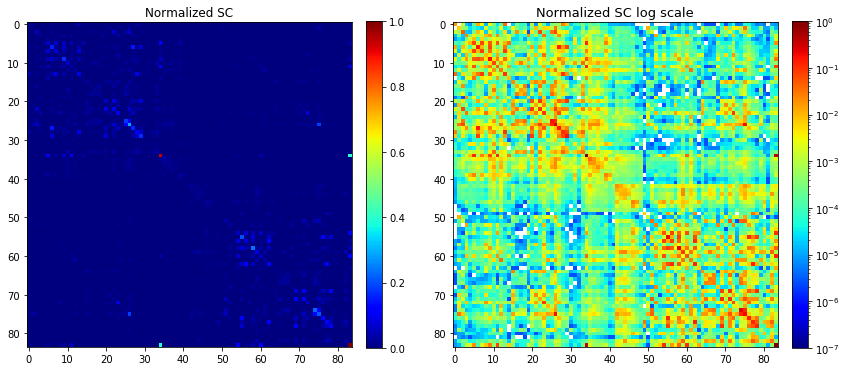

In [9]:
from matplotlib import colors, cm

plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.imshow((con.weights), interpolation='nearest', cmap='jet' )
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Normalized SC')

plt.subplot(122)
norm = colors.LogNorm(1e-7, con.weights.max())
im = plt.imshow(con.weights,norm=norm,cmap=cm.jet)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.gca().set_title('Normalized SC log scale', fontsize=13.0)
plt.savefig(os.path.join(results_dir,"Connectivity_CJ.png"))
plt.show()

## ROIs chosen as Epileptogenic/propagation zones

In [11]:
hz_val=-3.6
pz_val=-2.4
ez_val=-1.6

ez_idx = np.array([6, 34],  dtype=np.int32)
pz_wplng_idx = np.array([5,11], dtype=np.int32)
pz_kplng_idx = np.array([27], dtype=np.int32)
pz_idx = np.append(pz_kplng_idx, pz_wplng_idx)

# 6D epileptor Set up

In [13]:
epileptors = models.Epileptor(variables_of_interest=['x1', 'y1', 'z', 'x2', 'y2', 'g', 'x2 - x1'])

In [14]:
epileptors.r = np.array([1.0/2857])
epileptors.Ks = np.ones(num_regions)*(-1.0)
epileptors.tt = np.array([1.0])

In [15]:
simLen = 10*1000 # simulation length in milliseconds

In [17]:
epileptors.x0 = np.ones(num_regions)*hz_val
epileptors.x0[ez_idx] = ez_val
epileptors.x0[pz_idx] = pz_val

In [18]:
models.Epileptor??

In [19]:
epileptors

,value
"Iext [min, median, max]","[3.1, 3.1, 3.1]"
Iext dtype,float64
Iext shape,"(1,)"
"Iext2 [min, median, max]","[0.45, 0.45, 0.45]"
Iext2 dtype,float64
Iext2 shape,"(1,)"
"Kf [min, median, max]","[0, 0, 0]"
Kf dtype,float64
Kf shape,"(1,)"
"Ks [min, median, max]","[-1, -1, -1]"


In [20]:
coupl = coupling.Difference(a=np.array([1.0]))

In [21]:
mon_tavg = monitors.TemporalAverage(period=1.0)

In [22]:
noiseON = True

nsf = 1.0 # noise scaling factor

hiss = noise.Additive(nsig = nsf*np.array([0.01, 0.01, 0., 0.00015, 0.00015, 0.]))

if(noiseON):
    heunint = integrators.HeunStochastic(dt=0.04, noise=hiss)
else:
    heunint = integrators.HeunDeterministic(dt=0.04)

#### Find a fixed point to initialize the epileptor in a stable state


In [23]:
from scipy.optimize import fsolve

def get_equilibrium(model, init):
    nvars = len(model.state_variables)
    cvars = len(model.cvar)

    def func(x):
        fx = model.dfun(x.reshape((nvars, 1, 1)),
                        np.zeros((cvars, 1, 1)))
        return fx.flatten()

    x = fsolve(func, init)
    return x

In [24]:
epileptor_equil = models.Epileptor()
epileptor_equil.x0 = np.array([-3.0])
init_cond = get_equilibrium(epileptor_equil, np.array([0.0, 0.0, 3.0, -1.0, 1.0, 0.0]))
init_cond_reshaped = np.repeat(init_cond, num_regions).reshape((1, len(init_cond), num_regions, 1))

In [25]:
sim = simulator.Simulator(model=epileptors,
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          conduction_speed=np.inf,
                          integrator=heunint,
                          monitors=[mon_tavg])

sim.configure()

,value
Type,Simulator
conduction_speed,inf
connectivity,Connectivity gid: 1386617e-7501-4b8a-928c-c76f57f91476
coupling,Difference gid: 14d8b72a-bcfd-48b4-b8cf-09b7f4a6dfb3
gid,UUID('1682a25d-fd6d-4e7e-9e70-2ff2311b3f6c')
"initial_conditions [min, median, max]","[-18.7492, -0.625441, 4.05032]"
initial_conditions dtype,float64
initial_conditions shape,"(1, 6, 84, 1)"
integrator,HeunStochastic gid: 102df575-f917-421b-8588-86564b97f438
model,Epileptor gid: 8078310b-4712-4405-af3b-bdd87dd950e4


### Run Simulation

In [26]:
[(ttavg, tavg)] = sim.run(simulation_length=simLen)

In [27]:
time_steps=ttavg
X = tavg[:,0,:,0]
Z = tavg[:,2,:,0]

In [28]:
X.shape, Z.shape

((10000, 84), (10000, 84))

In [29]:
nn=np.r_[0:X.shape[1]]

### Plot  source activity

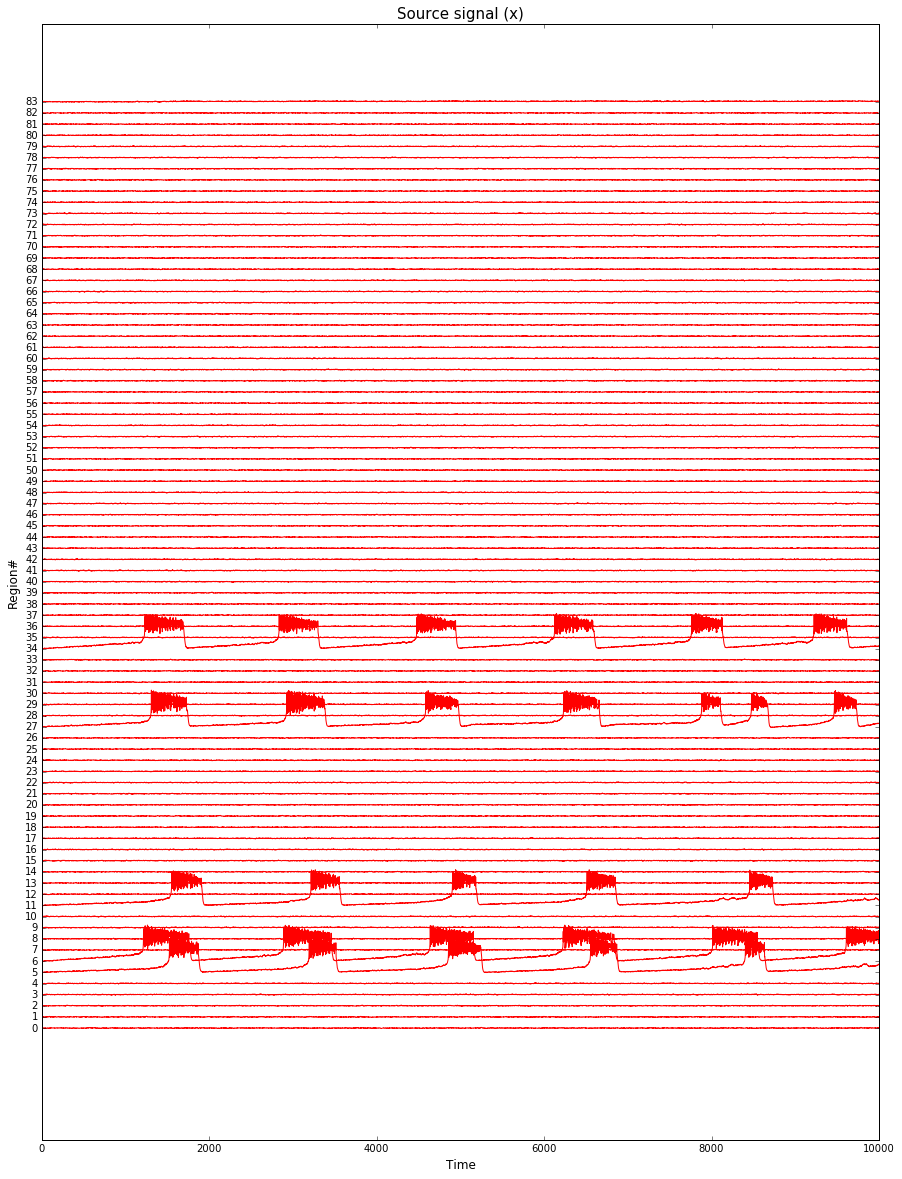

In [100]:
plt.figure(figsize=(15,20))
plt.plot(time_steps, X+ np.r_[0:len(nn)]+2, 'r')
plt.yticks(np.r_[0:len(nn)], np.r_[0:len(nn)],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(results_dir,"VEP_SL_patient1.png"))
plt.show()

In [101]:
LFP = tavg[:,0,:,0] + tavg[:,3,:,0]

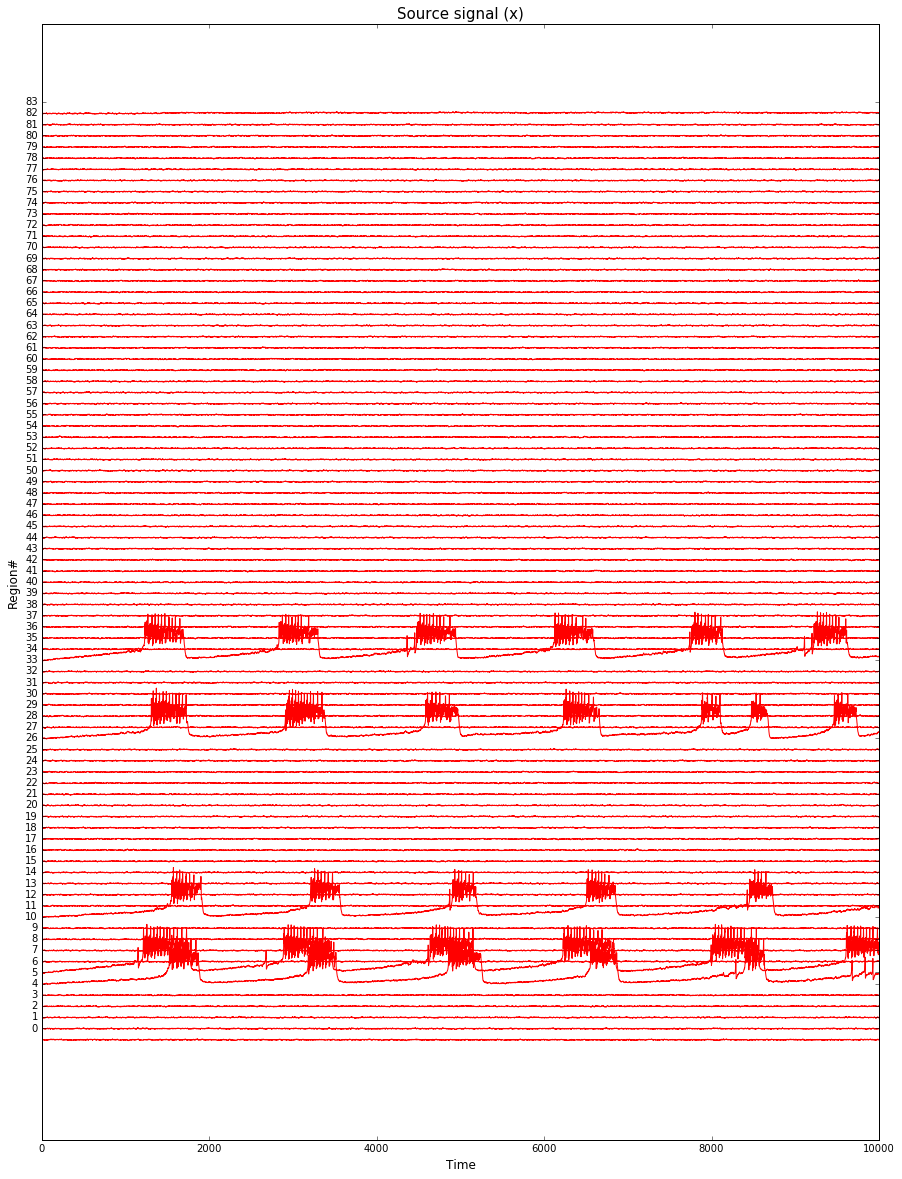

In [102]:
plt.figure(figsize=(15,20))
plt.plot(time_steps, LFP+ np.r_[0:len(nn)]+2, 'r')
plt.yticks(np.r_[0:len(nn)], np.r_[0:len(nn)],fontsize=10)
plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.ylabel('Region#',fontsize=12)
plt.savefig(os.path.join(results_dir,"VEP_LPF_patient1.png"))
plt.show()

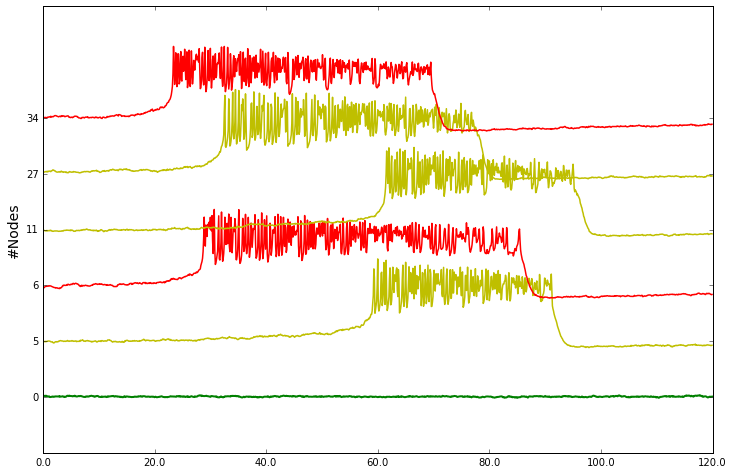

In [111]:
Nregions=np.r_[0:nn]

fidx =2600
lidx =3800

y=X[fidx:lidx,:].T

eni=array([0, 5,  6, 11, 27, 34])

plt.figure(figsize=(12,8))
for i, yi in enumerate(y[eni]):
         if eni[i] in ez_idx:  
             plt.plot(yi+2*i-0.5, 'r', linewidth=1.5)
         elif eni[i] in pz_idx:    
             plt.plot(yi+ 2*i-0.25, 'y', linewidth=1.5)
         else:
             plt.plot(yi+ 2*i, 'g', linewidth=2)
    
plt.ylabel('#Nodes',fontsize=14)
plt.xticks(np.arange(0,1201,200), 0.1*(np.arange(0,1201,200)),fontsize=10, rotation='horizontal')
plt.yticks(2*r_[:len(eni)]-2, [Nregions[i] for i in eni]);
plt.savefig(os.path.join(results_dir,"VEP_SL_ROIs_patient1.png"))
plt.show()

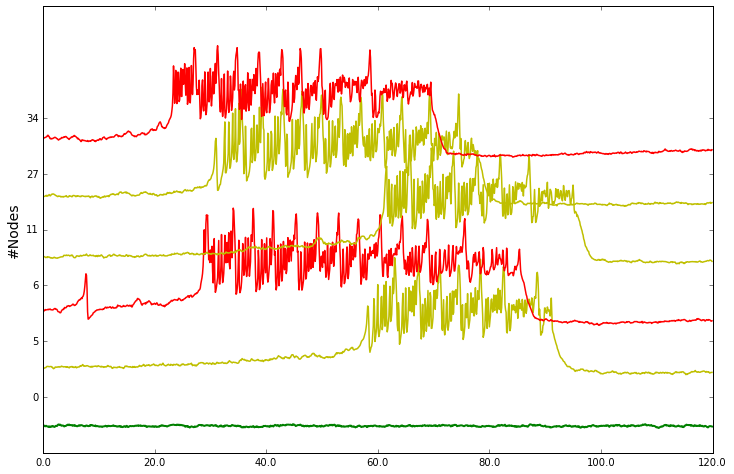

In [113]:
Nregions=np.r_[0:nn]

y=LFP[fidx:lidx,:].T

eni=array([0, 5,  6, 11, 27, 34])

plt.figure(figsize=(12,8))
for i, yi in enumerate(y[eni]):
         if eni[i] in ez_idx:  
             plt.plot(yi+2*i-0.5, 'r', linewidth=1.5)
         elif eni[i] in pz_idx:    
             plt.plot(yi+ 2*i-0.25, 'y', linewidth=1.5)
         else:
             plt.plot(yi+ 2*i, 'g', linewidth=2)

plt.ylabel('#Nodes',fontsize=14)
plt.xticks(np.arange(0,1201,200), 0.1*(np.arange(0,1201,200)),fontsize=10, rotation='horizontal')
plt.yticks(2*r_[:len(eni)]-2, [Nregions[i] for i in eni]);
plt.savefig(os.path.join(results_dir,"VEP_LPF_ROIs_patient1.png"))
plt.show()

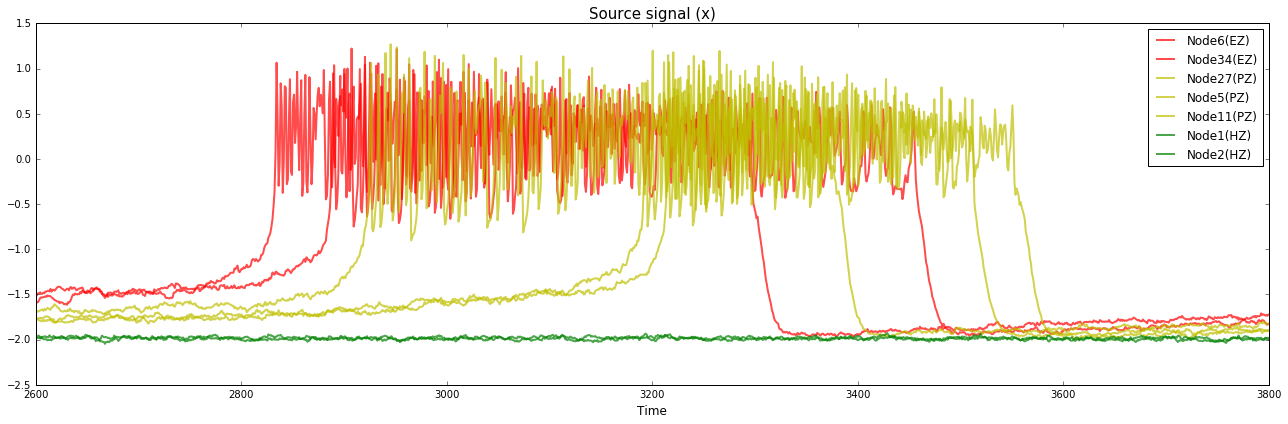

In [114]:
plt.figure(figsize=(18,6))
for roi in ez_idx:
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(EZ)', color='r', alpha=0.7, linewidth=2)
for roi in pz_idx:
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(PZ)', color='y', alpha=0.7, linewidth=2)
for roi in np.array([1,2]):
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(HZ)', color='g', alpha=0.7, linewidth=2)

plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"VEP_fastvariable_ROIs_patient1.png"))
plt.show()

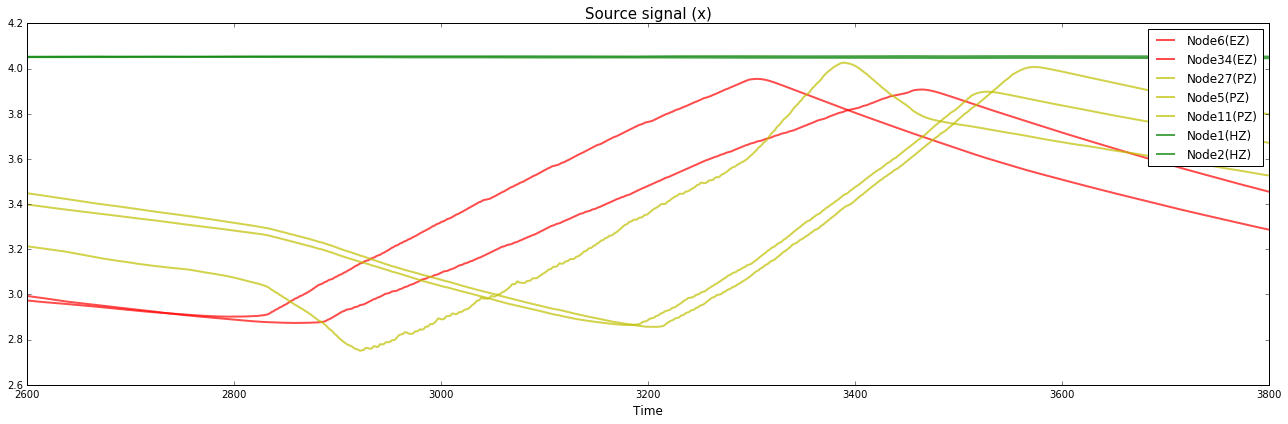

In [115]:
plt.figure(figsize=(18,6))
for roi in ez_idx:
    plt.plot(ttavg[fidx:lidx], Z[fidx:lidx,roi],label='Node'+ str(roi)+ '(EZ)', color='r', alpha=0.7, linewidth=2)
for roi in pz_idx:
    plt.plot(ttavg[fidx:lidx], Z[fidx:lidx,roi],label='Node'+ str(roi)+ '(PZ)', color='y', alpha=0.7, linewidth=2)
for roi in np.array([1,2]):
    plt.plot(ttavg[fidx:lidx], Z[fidx:lidx,roi],label='Node'+ str(roi)+ '(HZ)', color='g', alpha=0.7, linewidth=2)

plt.title("Source signal (x)",fontsize=15)
plt.xlabel('Time',fontsize=12)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(results_dir,"VEP_slowvariable_ROIs_patient1.png"))
plt.show()

In [116]:
ttavg[fidx:lidx].shape

(1200,)

In [117]:
X[fidx:lidx,:].shape

(1200, 84)

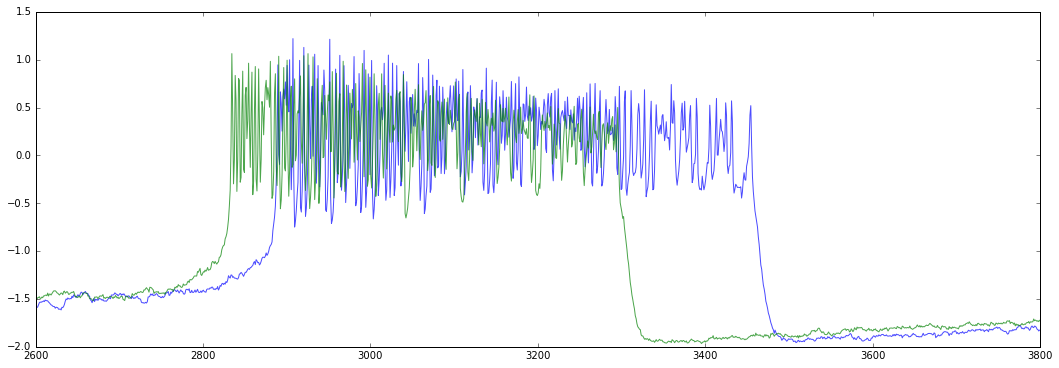

In [118]:
plt.figure(figsize=(18,6))
for roi in ez_idx:
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(EZ)',alpha=0.7)
plt.show()    

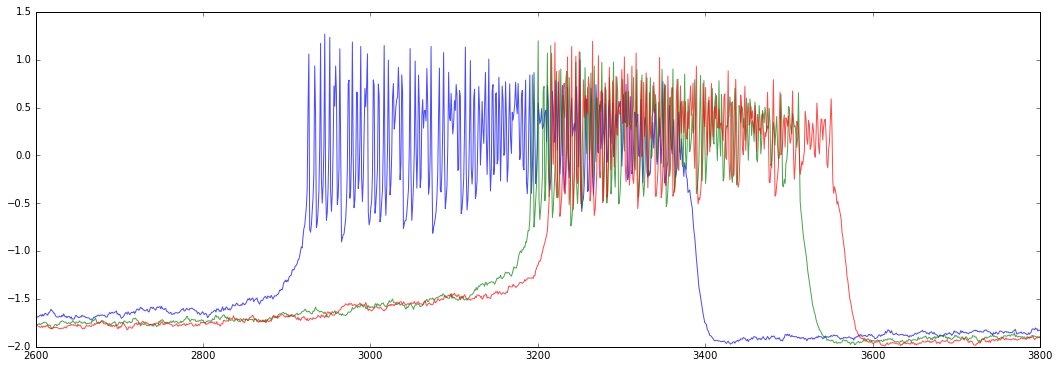

In [119]:
plt.figure(figsize=(18,6))
for roi in pz_idx:
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(PZ)',alpha=0.7)
plt.show()        

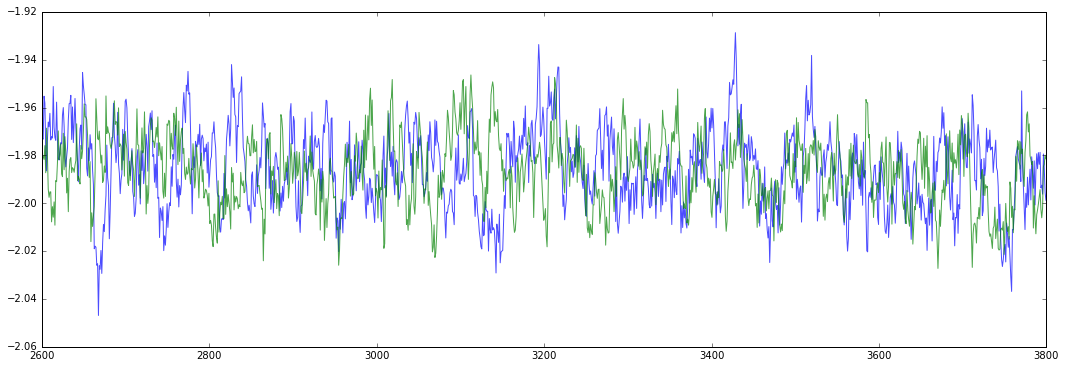

In [120]:
plt.figure(figsize=(18,6))
for roi in np.array([1,2]):
    plt.plot(ttavg[fidx:lidx], X[fidx:lidx,roi],label='Node'+ str(roi)+ '(HZ)',alpha=0.7)
plt.show()        

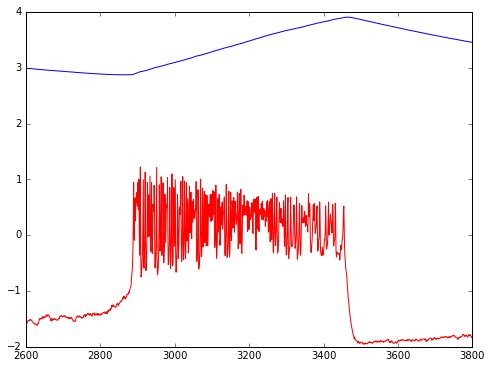

In [121]:
plt.figure(figsize=(8,6))
plt.plot(ttavg[fidx:lidx], X[fidx:lidx,6], 'r')
plt.plot(ttavg[fidx:lidx], Z[fidx:lidx,6], 'b')
plt.show()

### comparision with 2D epileptor for a single Epileptor

In [122]:
fidx =2600
lidx =3800

In [154]:
x_obs=X[fidx:lidx,6]
z_obs=Z[fidx:lidx,6]

In [155]:
x_obs.shape

(1200,)

In [156]:
random.seed(11442)

In [157]:
Nt, sigma = 120, 1e-1

In [158]:
dt=.1
Tend=Nt*dt
print ('dt:', dt)

('dt:', 0.1)


In [159]:
t0=0.0
Ts = arange(dt,Tend+dt,dt)

In [160]:
Tend = array([(Nt+1)*dt] , dtype='float32')

In [161]:
tau0=10.0
I1=3.1

In [164]:
x0_true=-1.6 
params_true=[x0_true]

In [169]:
xs, zs = [-1.5], [3.]

for i in range(Nt-1):
    x, z = xs[-1], zs[-1]
    dx =1.0 - x**3 - 2.0*x**2 - z + I1   
    dz =(1.0/tau0)*(4*(x-x0_true) - z)
    xs.append(x + dt * dx + 0*sqrt(dt) *sigma * randn())
    zs.append(z + dt * dz + 0*sqrt(dt) *sigma * randn())
    
xs,zs = array(xs), array(zs)

In [170]:
xs.shape

(120,)

In [171]:
ts = dt*r_[:xs.shape[0]]

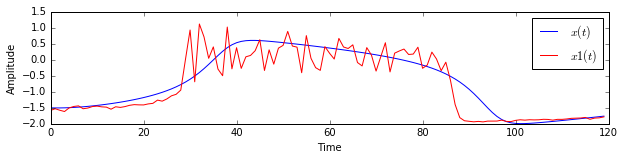

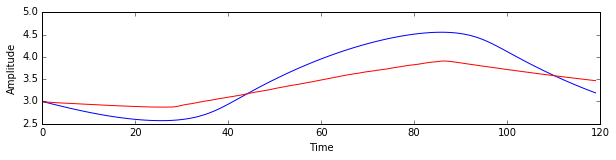

In [172]:
plt.figure(figsize=(10, 2))
plt.plot(xs, 'b', label='$x(t)$')
plt.plot(x_obs[::10], 'r', label='$x1(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 2))
plt.plot(zs, 'b', label='$x(t)$')
plt.plot(z_obs[::10], 'r', label='$z(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.show()